# Training Variational Quantum Models with Barren Plateaus Mitigation Strategies
*Training QNN treated with method 3 (Identity Blocks) of the BP mitigation strategy (Cancer)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen


In [2]:
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import *
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.utils import *

from IPython.display import clear_output

seed = 42
np.random.seed(seed)

In [3]:
from os.path import exists
from os import makedirs

In [4]:
# Global config for all experiments (data size, feature dim etc.) is stored here
from GLOBAL_CONFIG import *
# Remember to tag the method
METHOD_TAG = 'm3'

In [5]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
# estimator = Estimator()

In [6]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [7]:
if (exists(f'{LOG_PATH}/{METHOD_TAG}')):
    print(f'Found save folder: {LOG_PATH}/{METHOD_TAG}\n')
# else:
#     makedirs(f'{LOG_PATH}/{METHOD_TAG}')
#     print(f'Creating save folder: {LOG_PATH}/{METHOD_TAG}\n')

Found save folder: ./Logs-Cancer-v4/m3



In [43]:
surface3 = pd.read_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv', index_col=0)
path3 = pd.read_csv(f'{LOG_PATH}/{METHOD_TAG}/{METHOD_TAG}-3-Weights.csv', index_col=0)
path3[path3.shape[1]] = pd.read_csv(f'{LOG_PATH}/{METHOD_TAG}/{METHOD_TAG}-3-LossFunction.csv', index_col=0)
# surface3 = surface3.transpose().reset_index(drop=True).transpose()
path3 = path3.transpose().reset_index(drop=True).transpose()

## Cost Function Surface

In [9]:
feature_map = featureMapGenerator(FEATURE_DIM)
identity_block = preTrainedBlockGenerator(MAX_QUBITS_CLASSIFICATION, MAX_IDENTITIES_BLOCKS, overlay=IDENTITY_BLOCKS_OVERLAY, entanglement=ENTANGLEMENT, insert_barriers=True)
ansatz = identity_block['circuit']
qc=circuitBuilder(feature_map, ansatz)


id_dict = {k.name : v for k, v in identity_block['params_values'].items()}
initial_point = [id_dict[p.name] for p in list(ansatz.parameters)]

In [10]:
### Find what devices are available
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

### Force CPU - PyTorch+Qiskit too slow with GPU
devices = ('CPU')
devices

'CPU'

In [11]:
from qiskit.primitives import Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Estimator as AerEstimator # For device="GPU" option

seed = 2023

# Use GPU when present, otherwise CPU
if 'GPU' in devices:
    device = 'GPU'
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': 1000},
        transpile_options={"seed_transpiler": seed},
    )
else:
    device = 'CPU'
    estimator = Estimator()
    estimator.set_options(method='statevector')
    estimator.set_options(device=device)
    estimator.set_options(seed=seed)
    estimator.options

print(f'Selected device: {device}')

Selected device: CPU


### Generation of surface points
To ensure that the cost function surface of the trained model surrounds the optimisation curve (path)<br/>
the random perturbations are added to each cost point of the optimisation curve.

In [56]:
res = pd.DataFrame()
epochs = 5
perturb = np.pi/2

start = time.time()
for i in range(0, epochs):

    for path_pt in range(path3.shape[0]):
        print(f'iteration: {i}, point: {path_pt}')
        display(res.tail())
        opt_point = np.array(path3)[path_pt][0:-1]
        point_perturb = np.random.uniform(-perturb, perturb, ansatz.num_parameters)
        point = opt_point+point_perturb
        
        qnn = EstimatorQNN(
            circuit=qc,
            estimator=Estimator(),
            observables=GLOBAL_OPERATOR,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters
        )
    
        model = TorchConnector(qnn, initial_weights=point)
    
        loss_function = nn.L1Loss() #This is MAE loss
        optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)
    
        loss, weight = sampleWeightLoss(
            model, 
            X_train_t,
            y_train_t,
            optimizer = optimizer, 
            loss_function = loss_function
            )
        res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
        clear_output(wait=True)
elapsed = time.time() - start

surface3 = res
# pd.DataFrame(res).astype('float').to_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv')

iteration: 4, point: 99


,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
494,2.817762,0.364775,-5.546450,0.455398,-3.592380,-2.668570,-6.344610,-4.266527,-5.657792,-0.058066,...,-0.387869,-0.216072,6.708296,-5.722806,-1.395209,-1.662602,0.003102,-1.679546,4.827383,0.997461
495,1.846916,0.266078,-6.161117,0.794540,-2.411236,-3.119052,-5.338341,-3.612011,-6.964297,0.926981,...,1.391835,0.041737,6.931337,-5.127917,-1.573996,-0.591435,1.575690,0.406559,5.328423,1.009976
496,4.278926,-1.132022,-5.711121,-1.119169,-3.686363,-3.886200,-3.764004,-4.112406,-7.274496,0.566467,...,-0.622856,0.092559,7.089593,-5.577661,-0.496629,0.188814,-0.301185,0.186767,2.543262,1.005152
497,2.194225,0.668467,-5.378960,-1.096427,-4.102191,-2.897765,-6.401473,-4.174559,-4.655046,0.606839,...,1.666313,-0.408516,5.598578,-7.728637,-1.209861,-1.282757,-0.462032,-0.979613,4.080921,1.005219
498,2.240745,-0.103882,-5.850715,1.147370,-4.284703,-1.270869,-4.893589,-3.454764,-6.662132,-1.286489,...,1.254300,0.800957,6.751429,-4.731973,-1.335718,-1.972850,0.725814,-1.579637,4.408357,0.999929


### The older version of surface point generation
In this (commented out) version, the random surface points are generated only around the optimisation optimum,<br/>
rather than along the optimisation curve.

In [ ]:
# res = pd.DataFrame()
# epochs = 200
# perturb = (2*np.pi)/10

# start = time.time()
# for i in range(0, epochs):
#     print('iteration: ', i)
#     display(res.tail())
#     opt_point = np.array(path3)[-1][0:-1]
#     point_perturb = np.random.uniform(-np.pi/2, np.pi/2, ansatz.num_parameters)
#     point = opt_point+point_perturb
#     # point = initial_point + np.random.uniform(-0.1, 0.1, ansatz.num_parameters)
    
#     qnn = EstimatorQNN(
#         circuit=qc,
#         estimator=Estimator(),
#         observables=GLOBAL_OPERATOR,
#         input_params=feature_map.parameters,
#         weight_params=ansatz.parameters
#     )

#     model = TorchConnector(qnn, initial_weights=point)

#     loss_function = nn.L1Loss() #This is MAE loss
#     optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

#     loss, weight = sampleWeightLoss(
#         model, 
#         X_train_t,
#         y_train_t,
#         optimizer = optimizer, 
#         loss_function = loss_function
#         )
#     res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
#     clear_output(wait=True)
# elapsed = time.time() - start

# surface3 = res
# pd.DataFrame(res).astype('float').to_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv')

### Plot the 3D surface

In [65]:
# Print run statistics
print(f'{device} Fit\n'+
      f'\tQubits:\t\t{ansatz.num_qubits}\n'+
      f'\tDepth:\t\t{ansatz.depth()} (gates)\n'+
      f'\tWeights:\t{len(ansatz.parameters)} (parameters)\n'+
      f'\tEpochs:\t\t{epochs}\n'+
      f'\tTime:\t\t{elapsed:0.2f} sec')

CPU Fit
	Qubits:		8
	Depth:		78 (gates)
	Weights:	114 (parameters)
	Epochs:		5
	Time:		2736.05 sec


In [66]:
from sklearn.decomposition import PCA

def plotSurface(surface:pd.DataFrame, path=None, title = None, save:str = None, dpi = 80):
    '''
    use %matplotlib widget for interative plot!
    '''
    if path is not None:
        data = pd.concat([surface, path], ignore_index=True)
    else:
        data = surface

    parameters = data.iloc[:,:-1]
    zValue = data.iloc[:,-1]

    pca = PCA(n_components=2)
    pca.fit(parameters)
    principalSurfaceData = pca.transform(parameters)

    print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
    principalSurfaceDataDF = pd.DataFrame(principalSurfaceData, columns=['x', 'y'])
    principalSurfaceDataDF['z'] = zValue

    from mpl_toolkits.mplot3d import Axes3D
    surfaceXs = principalSurfaceDataDF['x']
    surfaceYs = principalSurfaceDataDF['y']
    surfaceZs = principalSurfaceDataDF['z']
    

    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel('Params PC1')
    ax.set_ylabel('Params PC2')
    ax.set_zlabel('Means Absolute Error')


    if title:
        ax.set_title(title)

    plot = ax.plot_trisurf(surfaceXs,
                       surfaceYs,
                       surfaceZs,
                       cmap=plt.get_cmap('rainbow_r'),
                       linewidth=1,
                       antialiased=False,
                       alpha=0.6)
    
    plt.colorbar(plot, shrink=0.5, aspect=5)

    if path is not None:
        pathParameters = path.iloc[:,:-1]
        pathZvalue = path.iloc[:,-1]
        principalPathData = pca.transform(pathParameters)
        principalPathDataDF = pd.DataFrame(principalPathData, columns=['x', 'y'])
        principalPathDataDF['z'] = pathZvalue
        # principalPathDataDF = principalSurfaceDataDF.iloc[-100:]

        
        ax.plot3D(principalPathDataDF['x'],
                principalPathDataDF['y'],
                principalPathDataDF['z'],
                color='red',
                linewidth=3,
                antialiased=False,
                alpha=1)

    plt.show()

    if save:
        plt.savefig(save)
        

%matplotlib widget
# plot_surface(surface0, 
#              path=path0, 
#              title='Gradient surface for method 0', dpi=100)
    

Explained Variance Ratio: [0.02085361 0.01856458]


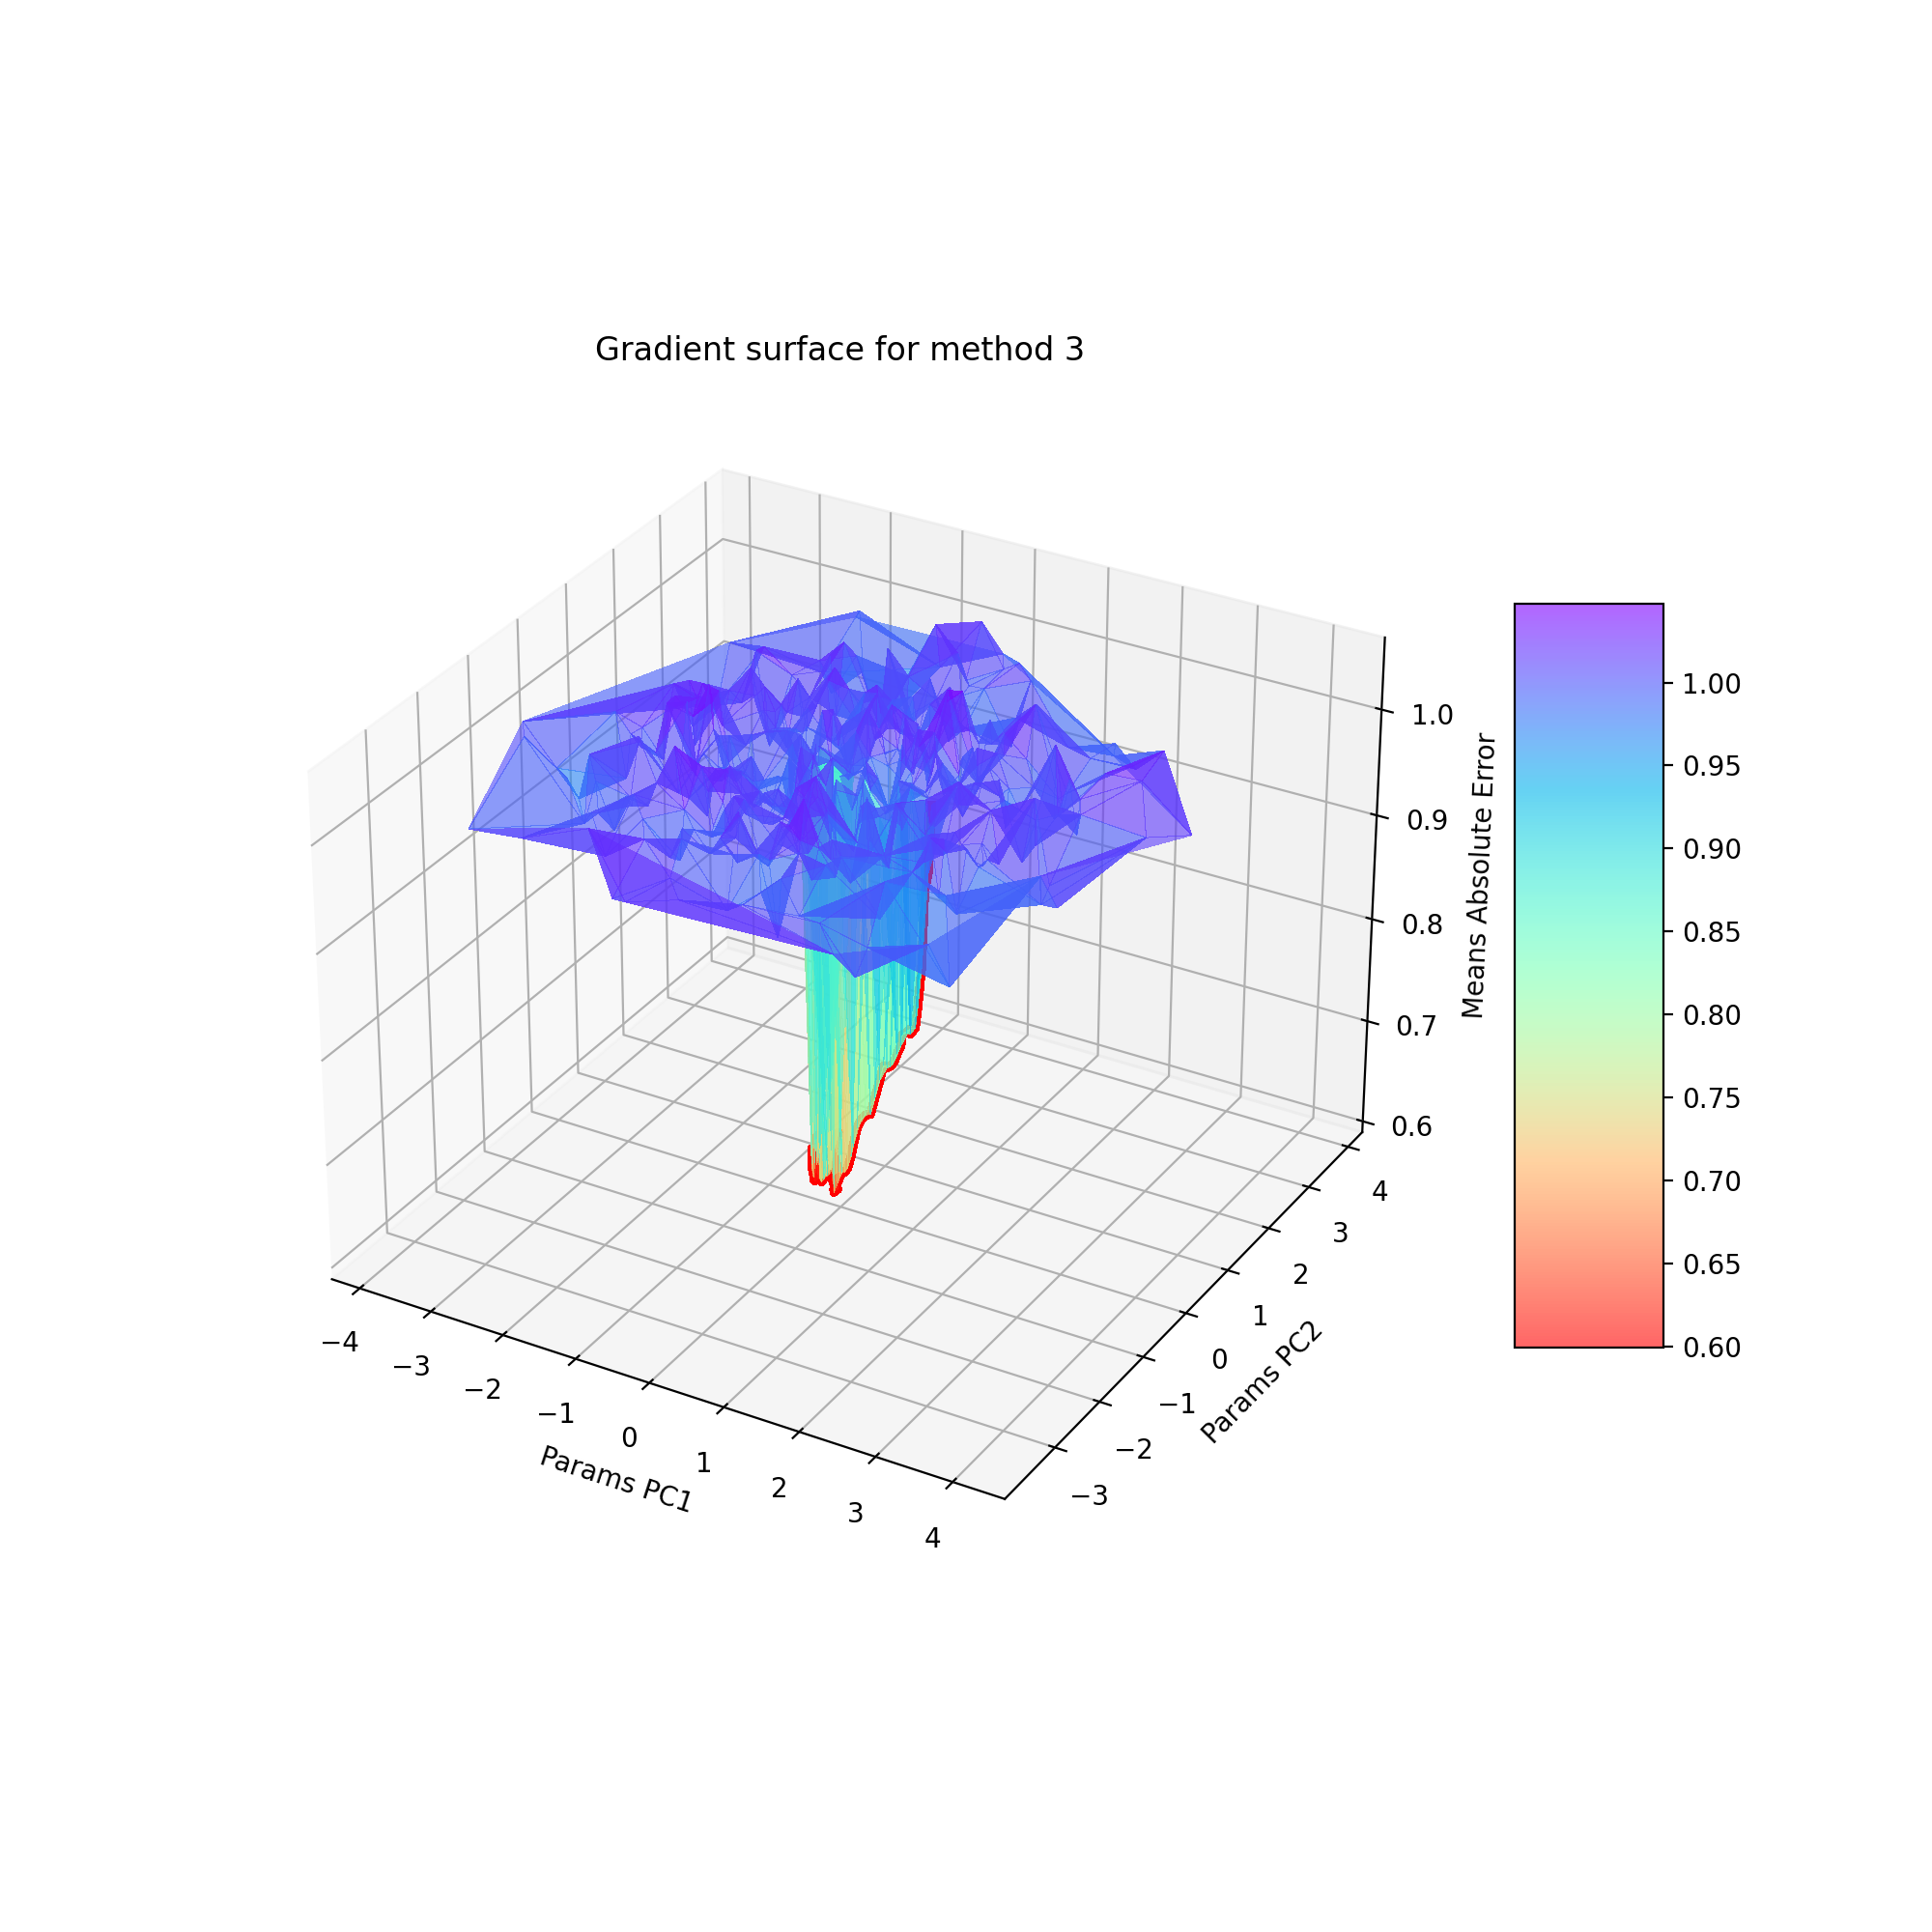

In [67]:
%matplotlib widget
plotSurface(surface3, path=path3, title='Gradient surface for method 3', dpi=200, save='m3.png')

In [60]:
!pip list | grep qiskit

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-experiments            0.5.4
qiskit-finance                0.4.0
qiskit-ibm-experiment         0.4.4
qiskit-ibm-provider           0.8.0
qiskit-ibm-runtime            0.18.0
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-terra                  0.45.2


In [61]:
!pip list | grep torch

torch                         2.0.1+cu118
torchaudio                    2.0.2+cu118
torchsummary                  1.5.1
torchvision                   0.15.2+cu118
